## ライブラリのインポートと設定

In [ ]:
# 日本の国土内での緯度経度クラスタリング分析
# HDBSCANとDBSCANの比較

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.metrics import  silhouette_score
import hdbscan
import folium
import warnings
warnings.filterwarnings('ignore')

# 日本語フォントの設定
plt.rcParams['font.family'] = 'Yu Gothic'
plt.rcParams['axes.unicode_minus'] = False

print("必要なライブラリのインポート完了")


必要なライブラリのインポート完了


## 日本の国土内でランダムな緯度経度データを生成

生成されたデータポイント数: 1200
緯度範囲: 24.0030 ~ 45.8092
経度範囲: 122.0003 ~ 145.8757


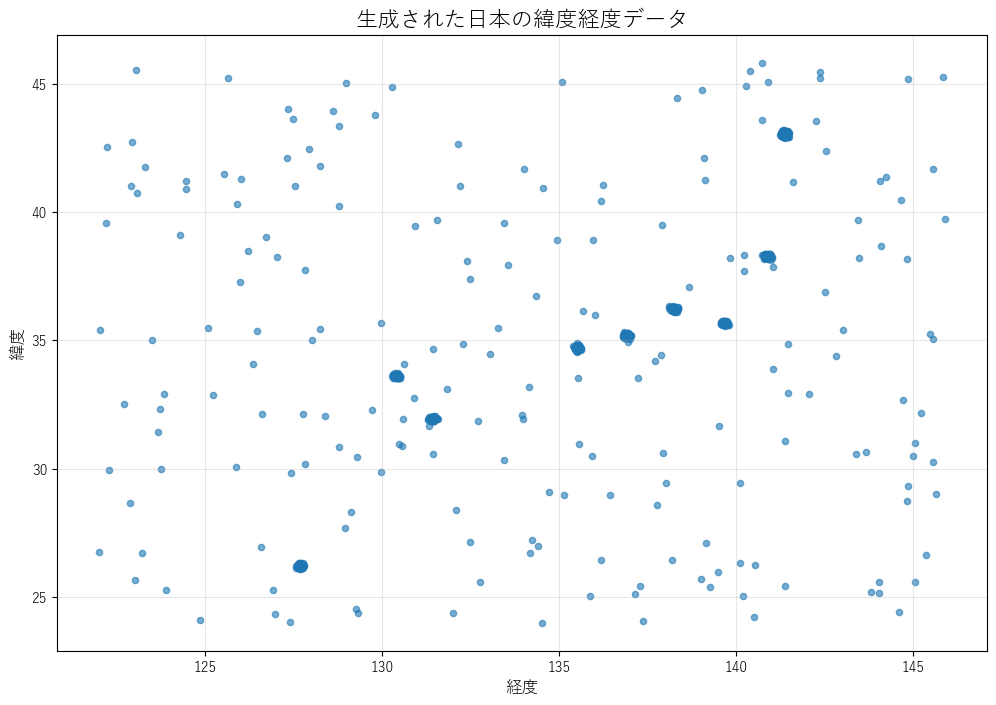

In [6]:
# 日本の国土範囲（概算）
# 緯度: 約24度〜46度（北緯）
# 経度: 約122度〜146度（東経）

np.random.seed(42)  # 再現性のため

# データポイント数
n_points = 1000

# 日本の主要地域を模擬したクラスター中心
cluster_centers = [
    (35.6762, 139.6503),  # 東京
    (34.6937, 135.5023),  # 大阪
    (35.1815, 136.9066),  # 名古屋
    (43.0618, 141.3545),  # 札幌
    (33.5902, 130.4017),  # 福岡
    (38.2688, 140.8721),  # 仙台
    (26.2124, 127.6809),  # 那覇
    (36.2048, 138.2529),  # 長野
    (42.9849, 141.3645),  # 旭川
    (31.9522, 131.4239),  # 宮崎
]

# 各クラスターからランダムにポイントを生成
data_points = []
for center_lat, center_lon in cluster_centers:
    # 各クラスターから100ポイントずつ生成
    n_cluster_points = n_points // len(cluster_centers)
    
    # 緯度経度のばらつき（約10km程度）
    lat_std = 0.05  # 約5.5km
    lon_std = 0.05  # 約5.5km
    
    cluster_lats = np.random.normal(center_lat, lat_std, n_cluster_points)
    cluster_lons = np.random.normal(center_lon, lon_std, n_cluster_points)
    
    for lat, lon in zip(cluster_lats, cluster_lons):
        data_points.append([lat, lon])

# ノイズポイントを追加（全体に散らばる）
n_noise = 200
noise_lats = np.random.uniform(24, 46, n_noise)
noise_lons = np.random.uniform(122, 146, n_noise)

for lat, lon in zip(noise_lats, noise_lons):
    data_points.append([lat, lon])

# DataFrameに変換
df = pd.DataFrame(data_points, columns=['latitude', 'longitude'])

print(f"生成されたデータポイント数: {len(df)}")
print(f"緯度範囲: {df['latitude'].min():.4f} ~ {df['latitude'].max():.4f}")
print(f"経度範囲: {df['longitude'].min():.4f} ~ {df['longitude'].max():.4f}")

# データの可視化
plt.figure(figsize=(12, 8))
plt.scatter(df['longitude'], df['latitude'], alpha=0.6, s=20)
plt.title('生成された日本の緯度経度データ', fontsize=16)
plt.xlabel('経度', fontsize=12)
plt.ylabel('緯度', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

## データの前処理とスケーリング

In [ ]:
# データの前処理
print("データの基本統計:")
print(df.describe())

# 緯度経度をメートル単位に変換（近似）
# 1度の緯度 ≈ 111,000 m
# 1度の経度 ≈ 111,000 * cos(緯度) m

def lat_lon_to_meters(lat, lon):
    """緯度経度をメートル単位に変換（簡易版）"""
    lat_m = lat * 111000  # 緯度をメートルに変換
    lon_m = lon * 111000 * np.cos(np.radians(lat))  # 経度をメートルに変換
    return lat_m, lon_m

# メートル単位に変換
df['lat_m'] = df['latitude'] * 111000
df['lon_m'] = df['longitude'] * 111000 * np.cos(np.radians(df['latitude']))

# スケーリング用のデータ
X_meters = df[['lat_m', 'lon_m']].values

print("\nスケーリング後のデータ形状:", X_meters.shape)
print("スケーリング後の基本統計:")
print(pd.DataFrame(X_meters, columns=['lat_m_scaled', 'lon_m_scaled']).describe())

データの基本統計:
          latitude    longitude         lat_m         lon_m
count  1200.000000  1200.000000  1.200000e+03  1.200000e+03
mean     35.563097   135.978891  3.947504e+06  1.221155e+07
std       5.075816     5.246843  5.634156e+05  6.026020e+05
min      24.002963   122.000279  2.664329e+06  9.567291e+06
25%      33.531292   131.392784  3.721973e+06  1.204587e+07
50%      35.249888   136.935292  3.912738e+06  1.236925e+07
75%      38.293862   140.873987  4.250619e+06  1.242986e+07
max      45.809214   145.875663  5.084823e+06  1.461196e+07

スケーリング後のデータ形状: (1200, 2)
スケーリング後の基本統計:
       lat_m_scaled  lon_m_scaled
count  1.200000e+03  1.200000e+03
mean   3.947504e+06  1.221155e+07
std    5.634156e+05  6.026020e+05
min    2.664329e+06  9.567291e+06
25%    3.721973e+06  1.204587e+07
50%    3.912738e+06  1.236925e+07
75%    4.250619e+06  1.242986e+07
max    5.084823e+06  1.461196e+07


##  DBSCANクラスタリングの実装とパラメータチューニング

=== DBSCANクラスタリング ===

DBSCANの主要パラメータ:
1. eps: 近傍点を探索する半径（メートル）
2. min_samples: クラスターを形成するための最小点数

手順:
1. epsパラメータを様々な値で試行
2. min_samplesはデータサイズに応じて調整
3. クラスター数とノイズ点の割合を確認
4. シルエットスコアでクラスタリング品質を評価


DBSCANパラメータチューニング結果:
      eps  min_samples  n_clusters  n_noise  noise_ratio  silhouette_score
11   5000           20           9      352     0.293333          0.949721
10   5000           15           9      298     0.248333          0.945912
9    5000           10           9      249     0.207500          0.940441
8    5000            5           9      219     0.182500          0.937969
13  10000           10           9      207     0.172500          0.935389
15  10000           20           9      208     0.173333          0.935388
14  10000           15           9      208     0.173333          0.935388
19  15000           20           9      203     0.169167          0.934136
12  10000            5           9      202     0.168333          0.933429
18  15000           15        

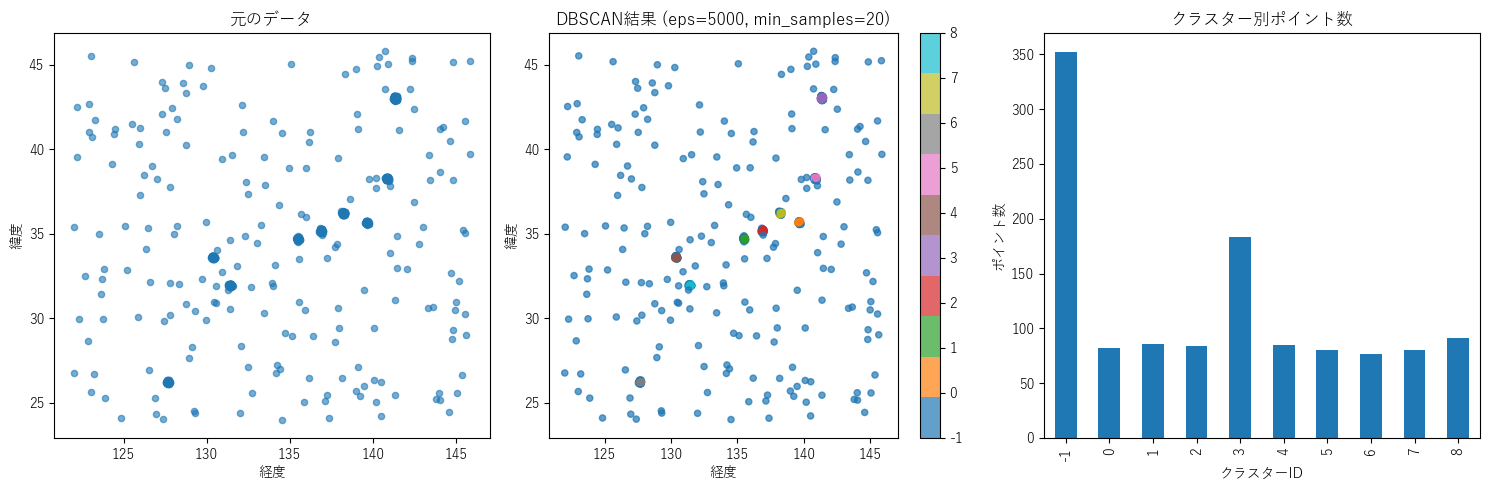

In [ ]:
# DBSCANクラスタリング
print("=== DBSCANクラスタリング ===")

# パラメータの説明
print("""
DBSCANの主要パラメータ:
1. eps: 近傍点を探索する半径（メートル）
2. min_samples: クラスターを形成するための最小点数

手順:
1. epsパラメータを様々な値で試行
2. min_samplesはデータサイズに応じて調整
3. クラスター数とノイズ点の割合を確認
4. シルエットスコアでクラスタリング品質を評価
""")

# 様々なeps値でDBSCANを試行
eps_values = [1000, 2000, 5000, 10000, 15000, 20000]  # メートル
min_samples_values = [5, 10, 15, 20]

best_score = -1
best_params = {}
best_labels = None

results_dbscan = []

for eps in eps_values:
    for min_samples in min_samples_values:
        # DBSCAN実行
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_meters)
        
        # クラスタリング結果の評価
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        noise_ratio = n_noise / len(labels)
        
        # シルエットスコア（ノイズ点を除く）
        if n_clusters > 1:
            mask = labels != -1
            if sum(mask) > 1:
                try:
                    silhouette_avg = silhouette_score(X_meters[mask], labels[mask])
                except:
                    silhouette_avg = -1
            else:
                silhouette_avg = -1
        else:
            silhouette_avg = -1
        
        results_dbscan.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'noise_ratio': noise_ratio,
            'silhouette_score': silhouette_avg
        })
        
        # 最良の結果を記録（クラスターが存在し、シルエットスコアが有効な場合）
        if silhouette_avg > best_score and n_clusters > 0 and silhouette_avg != -1:
            best_score = silhouette_avg
            best_params = {'eps': eps, 'min_samples': min_samples}
            best_labels = labels.copy()

# 結果をDataFrameで表示
results_df = pd.DataFrame(results_dbscan)
print("\nDBSCANパラメータチューニング結果:")
print(results_df.sort_values('silhouette_score', ascending=False).head(10))

# best_paramsが空でないかチェック
if best_params:
    print(f"\n最良のパラメータ: eps={best_params['eps']}, min_samples={best_params['min_samples']}")
    print(f"最良のシルエットスコア: {best_score:.4f}")
    
    # 最良の結果でクラスタリング実行
    best_dbscan = DBSCAN(eps=best_params['eps'], min_samples=best_params['min_samples'])
    best_dbscan_labels = best_dbscan.fit_predict(X_meters)
    
    # 結果の可視化
    plt.figure(figsize=(15, 5))
    
    # 元のデータ
    plt.subplot(1, 3, 1)
    plt.scatter(df['longitude'], df['latitude'], alpha=0.6, s=20)
    plt.title('元のデータ')
    plt.xlabel('経度')
    plt.ylabel('緯度')
    
    # DBSCAN結果
    plt.subplot(1, 3, 2)
    scatter = plt.scatter(df['longitude'], df['latitude'], c=best_dbscan_labels, 
                         cmap='tab10', alpha=0.7, s=20)
    plt.title(f'DBSCAN結果 (eps={best_params["eps"]}, min_samples={best_params["min_samples"]})')
    plt.xlabel('経度')
    plt.ylabel('緯度')
    plt.colorbar(scatter)
    
    # クラスター別の統計
    plt.subplot(1, 3, 3)
    cluster_counts = pd.Series(best_dbscan_labels).value_counts().sort_index()
    cluster_counts.plot(kind='bar')
    plt.title('クラスター別ポイント数')
    plt.xlabel('クラスターID')
    plt.ylabel('ポイント数')
    
    plt.tight_layout()
    plt.show()
 

##  HDBSCANクラスタリングの実装とパラメータチューニング

=== HDBSCANクラスタリング ===

HDBSCANの主要パラメータ:
1. min_cluster_size: クラスターの最小サイズ
2. min_samples: コアポイントの最小サンプル数
3. cluster_selection_epsilon: クラスター選択の閾値

手順:
1. min_cluster_sizeを様々な値で試行
2. min_samplesを調整してノイズ点の割合を制御
3. クラスター数とクラスタリング品質を評価
4. DBSCANとの結果を比較


HDBSCANパラメータチューニング結果:
    min_cluster_size  min_samples  n_clusters  n_noise  noise_ratio  \
2                 10           15          10      140     0.116667   
19               100           20           9      143     0.119167   
7                 20           20           9      143     0.119167   
3                 10           20           9      143     0.119167   
15                50           20           9      143     0.119167   
11                30           20           9      143     0.119167   
1                 10           10          11      105     0.087500   
0                 10            5          12       90     0.075000   
8                 30            5           9      124     0.103333   
12               

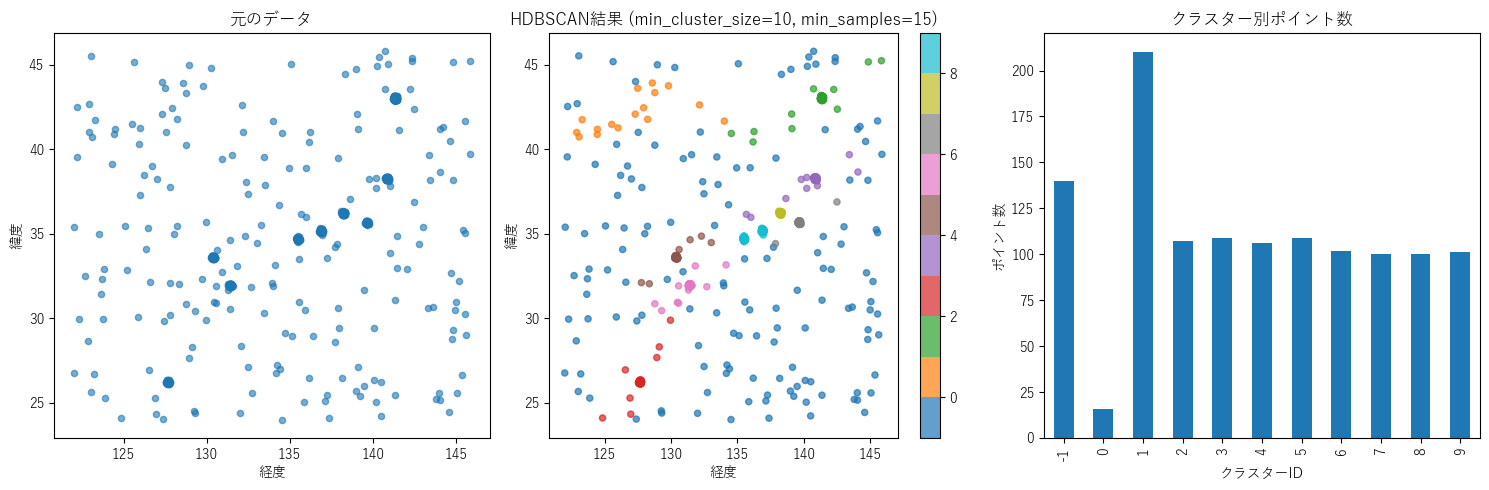

In [14]:
# HDBSCANクラスタリング
print("=== HDBSCANクラスタリング ===")

# パラメータの説明
print("""
HDBSCANの主要パラメータ:
1. min_cluster_size: クラスターの最小サイズ
2. min_samples: コアポイントの最小サンプル数
3. cluster_selection_epsilon: クラスター選択の閾値

手順:
1. min_cluster_sizeを様々な値で試行
2. min_samplesを調整してノイズ点の割合を制御
3. クラスター数とクラスタリング品質を評価
4. DBSCANとの結果を比較
""")

# 様々なパラメータでHDBSCANを試行
min_cluster_size_values = [10, 20, 30, 50, 100]
min_samples_values = [5, 10, 15, 20]

best_hdbscan_score = -1
best_hdbscan_params = {}
best_hdbscan_labels = None

results_hdbscan = []

for min_cluster_size in min_cluster_size_values:
    for min_samples in min_samples_values:
        # HDBSCAN実行
        hdbscan_clusterer = hdbscan.HDBSCAN(
            min_cluster_size=min_cluster_size,
            min_samples=min_samples,
            metric='euclidean'
        )
        labels = hdbscan_clusterer.fit_predict(X_meters)
        
        # クラスタリング結果の評価
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        noise_ratio = n_noise / len(labels)
        
        # シルエットスコア（ノイズ点を除く）
        if n_clusters > 1:
            mask = labels != -1
            if sum(mask) > 1:
                try:
                    silhouette_avg = silhouette_score(X_meters[mask], labels[mask])
                except:
                    silhouette_avg = -1
            else:
                silhouette_avg = -1
        else:
            silhouette_avg = -1
        
        results_hdbscan.append({
            'min_cluster_size': min_cluster_size,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'noise_ratio': noise_ratio,
            'silhouette_score': silhouette_avg
        })
        
        # 最良の結果を記録
        if silhouette_avg > best_hdbscan_score and n_clusters > 0:
            best_hdbscan_score = silhouette_avg
            best_hdbscan_params = {'min_cluster_size': min_cluster_size, 'min_samples': min_samples}
            best_hdbscan_labels = labels.copy()

# 結果をDataFrameで表示
results_hdbscan_df = pd.DataFrame(results_hdbscan)
print("\nHDBSCANパラメータチューニング結果:")
print(results_hdbscan_df.sort_values('silhouette_score', ascending=False).head(10))

print(f"\n最良のパラメータ: min_cluster_size={best_hdbscan_params['min_cluster_size']}, min_samples={best_hdbscan_params['min_samples']}")
print(f"最良のシルエットスコア: {best_hdbscan_score:.4f}")

# 最良の結果でクラスタリング実行
best_hdbscan = hdbscan.HDBSCAN(
    min_cluster_size=best_hdbscan_params['min_cluster_size'],
    min_samples=best_hdbscan_params['min_samples'],
    metric='euclidean'
)
best_hdbscan_labels = best_hdbscan.fit_predict(X_meters)

# 結果の可視化
plt.figure(figsize=(15, 5))

# 元のデータ
plt.subplot(1, 3, 1)
plt.scatter(df['longitude'], df['latitude'], alpha=0.6, s=20)
plt.title('元のデータ')
plt.xlabel('経度')
plt.ylabel('緯度')

# HDBSCAN結果
plt.subplot(1, 3, 2)
scatter = plt.scatter(df['longitude'], df['latitude'], c=best_hdbscan_labels, 
                     cmap='tab10', alpha=0.7, s=20)
plt.title(f'HDBSCAN結果 (min_cluster_size={best_hdbscan_params["min_cluster_size"]}, min_samples={best_hdbscan_params["min_samples"]})')
plt.xlabel('経度')
plt.ylabel('緯度')
plt.colorbar(scatter)

# クラスター別の統計
plt.subplot(1, 3, 3)
cluster_counts = pd.Series(best_hdbscan_labels).value_counts().sort_index()
cluster_counts.plot(kind='bar')
plt.title('クラスター別ポイント数')
plt.xlabel('クラスターID')
plt.ylabel('ポイント数')

plt.tight_layout()
plt.show()

##  DBSCANとHDBSCANの結果比較

=== DBSCAN vs HDBSCAN 比較 ===

手法別比較結果:
        手法  クラスター数  ノイズ点    ノイズ点割合  シルエットスコア
0   DBSCAN       9   352  0.293333  0.949721
1  HDBSCAN      10   140  0.116667  0.896792

=== 詳細分析 ===

DBSCAN - クラスターサイズ統計:
  最小クラスターサイズ: 77
  最大クラスターサイズ: 352
  平均クラスターサイズ: 120.0
  標準偏差: 87.4

HDBSCAN - クラスターサイズ統計:
  最小クラスターサイズ: 16
  最大クラスターサイズ: 210
  平均クラスターサイズ: 109.1
  標準偏差: 44.8


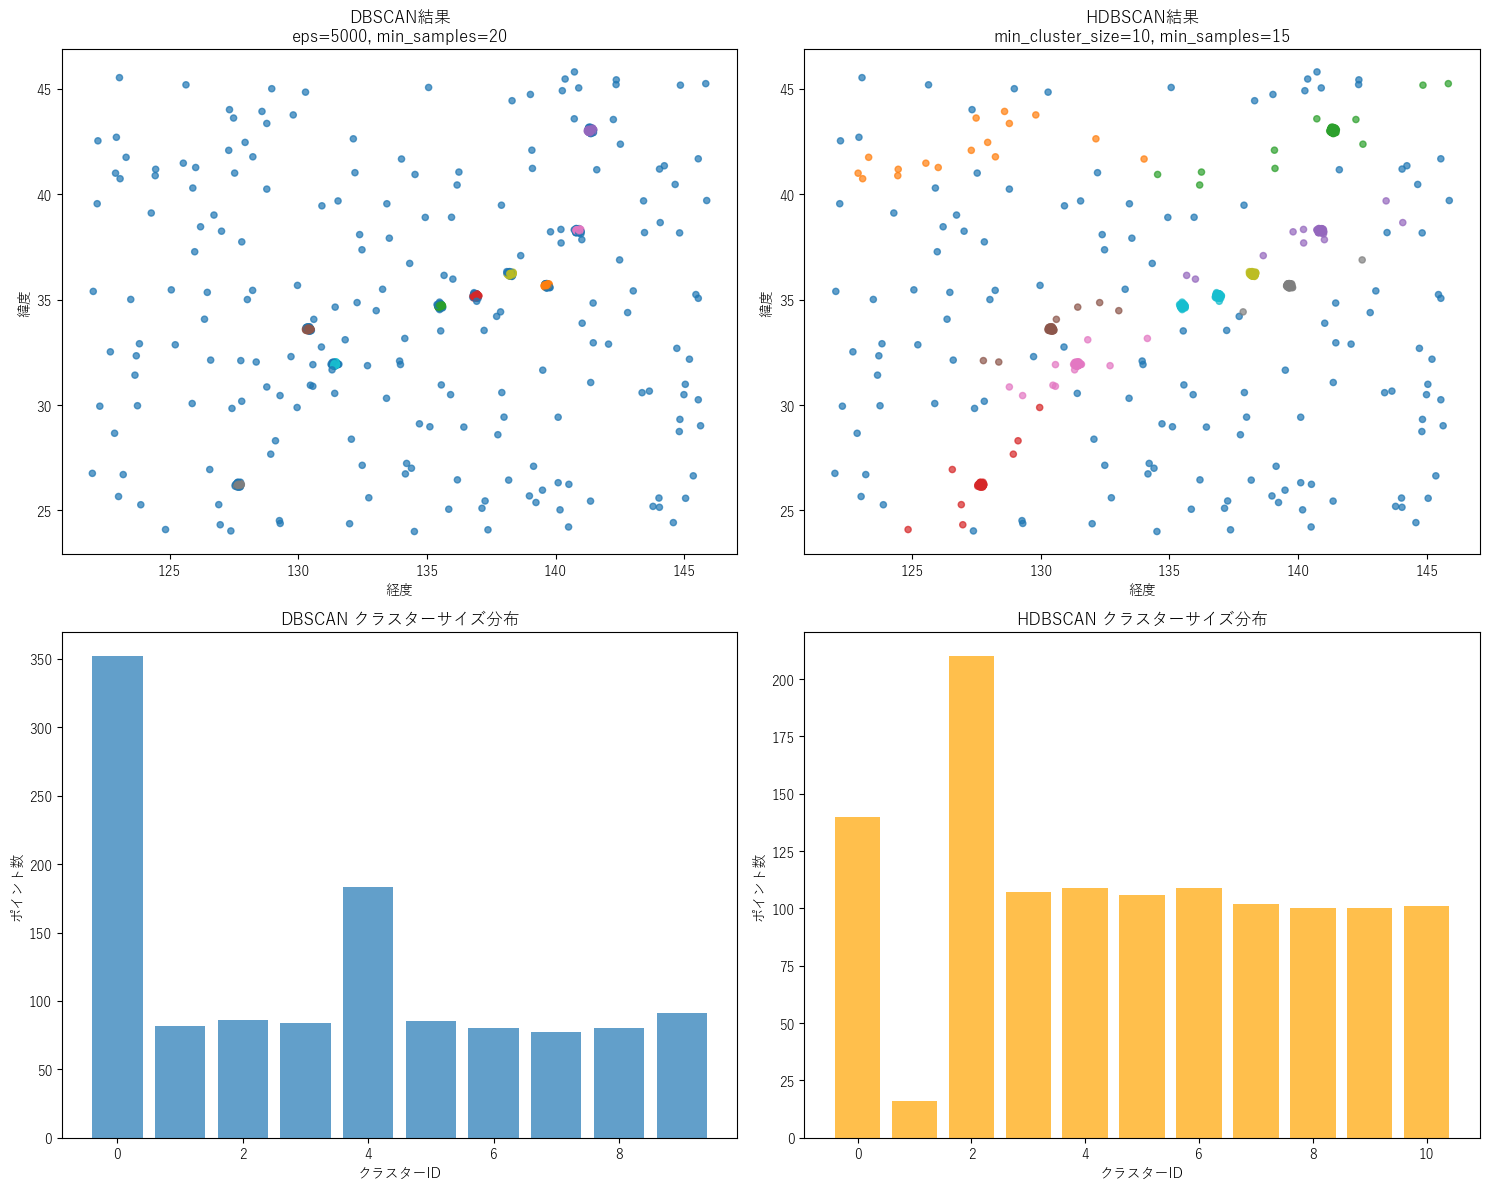

In [15]:
# DBSCANとHDBSCANの結果比較
print("=== DBSCAN vs HDBSCAN 比較 ===")

# 両手法の結果を比較
comparison_data = {
    '手法': ['DBSCAN', 'HDBSCAN'],
    'クラスター数': [
        len(set(best_dbscan_labels)) - (1 if -1 in best_dbscan_labels else 0),
        len(set(best_hdbscan_labels)) - (1 if -1 in best_hdbscan_labels else 0)
    ],
    'ノイズ点': [
        list(best_dbscan_labels).count(-1),
        list(best_hdbscan_labels).count(-1)
    ],
    'ノイズ点割合': [
        list(best_dbscan_labels).count(-1) / len(best_dbscan_labels),
        list(best_hdbscan_labels).count(-1) / len(best_hdbscan_labels)
    ],
    'シルエットスコア': [best_score, best_hdbscan_score]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n手法別比較結果:")
print(comparison_df)

# 詳細な比較分析
print("\n=== 詳細分析 ===")

# クラスターサイズの分布比較
dbscan_cluster_sizes = pd.Series(best_dbscan_labels).value_counts().sort_index()
hdbscan_cluster_sizes = pd.Series(best_hdbscan_labels).value_counts().sort_index()

print(f"\nDBSCAN - クラスターサイズ統計:")
print(f"  最小クラスターサイズ: {dbscan_cluster_sizes.min()}")
print(f"  最大クラスターサイズ: {dbscan_cluster_sizes.max()}")
print(f"  平均クラスターサイズ: {dbscan_cluster_sizes.mean():.1f}")
print(f"  標準偏差: {dbscan_cluster_sizes.std():.1f}")

print(f"\nHDBSCAN - クラスターサイズ統計:")
print(f"  最小クラスターサイズ: {hdbscan_cluster_sizes.min()}")
print(f"  最大クラスターサイズ: {hdbscan_cluster_sizes.max()}")
print(f"  平均クラスターサイズ: {hdbscan_cluster_sizes.mean():.1f}")
print(f"  標準偏差: {hdbscan_cluster_sizes.std():.1f}")

# 可視化比較
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# DBSCAN結果
scatter1 = axes[0,0].scatter(df['longitude'], df['latitude'], c=best_dbscan_labels, 
                             cmap='tab10', alpha=0.7, s=20)
axes[0,0].set_title(f'DBSCAN結果\neps={best_params["eps"]}, min_samples={best_params["min_samples"]}')
axes[0,0].set_xlabel('経度')
axes[0,0].set_ylabel('緯度')

# HDBSCAN結果
scatter2 = axes[0,1].scatter(df['longitude'], df['latitude'], c=best_hdbscan_labels, 
                             cmap='tab10', alpha=0.7, s=20)
axes[0,1].set_title(f'HDBSCAN結果\nmin_cluster_size={best_hdbscan_params["min_cluster_size"]}, min_samples={best_hdbscan_params["min_samples"]}')
axes[0,1].set_xlabel('経度')
axes[0,1].set_ylabel('緯度')

# クラスターサイズ分布比較
axes[1,0].bar(range(len(dbscan_cluster_sizes)), dbscan_cluster_sizes.values, alpha=0.7, label='DBSCAN')
axes[1,0].set_title('DBSCAN クラスターサイズ分布')
axes[1,0].set_xlabel('クラスターID')
axes[1,0].set_ylabel('ポイント数')

axes[1,1].bar(range(len(hdbscan_cluster_sizes)), hdbscan_cluster_sizes.values, alpha=0.7, label='HDBSCAN', color='orange')
axes[1,1].set_title('HDBSCAN クラスターサイズ分布')
axes[1,1].set_xlabel('クラスターID')
axes[1,1].set_ylabel('ポイント数')

plt.tight_layout()
plt.show()

## 地図上での可視化（Folium使用）

In [16]:
# 地図上での可視化（DBSCAN と HDBSCAN の比較）
print("=== 地図上での可視化（DBSCAN vs HDBSCAN） ===")

# 日本の中心座標
japan_center = [df['latitude'].mean(), df['longitude'].mean()]

# 地図の作成
m = folium.Map(location=japan_center, zoom_start=6, tiles='OpenStreetMap')

# クラスター別の色リスト
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 
          'beige', 'darkgreen', 'darkblue', 'darkpurple', 'pink', 'lightblue', 
          'lightgreen', 'gray', 'black', 'lightgray']

# レイヤーグループを作成
dbscan_group = folium.FeatureGroup(name='DBSCAN結果')
hdbscan_group = folium.FeatureGroup(name='HDBSCAN結果')

# DBSCAN結果を地図上にプロット
print("DBSCAN結果を地図上にプロット中...")
for idx, row in df.iterrows():
    cluster_id = best_dbscan_labels[idx]
    if cluster_id == -1:
        # ノイズ点は小さな黒い点で表示
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=3,
            color='black',
            fill=True,
            fillColor='black',
            fillOpacity=0.7,
            popup=f'DBSCAN ノイズ点 (ID: {idx})',
            tooltip=f'DBSCAN ノイズ'
        ).add_to(dbscan_group)
    else:
        # クラスター点は色分けして表示
        color = colors[cluster_id % len(colors)]
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=4,
            color=color,
            fill=True,
            fillColor=color,
            fillOpacity=0.7,
            popup=f'DBSCAN クラスター{cluster_id} (ID: {idx})',
            tooltip=f'DBSCAN C{cluster_id}'
        ).add_to(dbscan_group)

# DBSCAN クラスター中心を表示
for cluster_id in set(best_dbscan_labels):
    if cluster_id != -1:
        cluster_points = df[best_dbscan_labels == cluster_id]
        center_lat = cluster_points['latitude'].mean()
        center_lon = cluster_points['longitude'].mean()
        
        folium.Marker(
            location=[center_lat, center_lon],
            icon=folium.Icon(color='red', icon='star'),
            popup=f'DBSCAN クラスター{cluster_id}中心<br>ポイント数: {len(cluster_points)}',
            tooltip=f'DBSCAN C{cluster_id}中心'
        ).add_to(dbscan_group)

# HDBSCAN結果を地図上にプロット
print("HDBSCAN結果を地図上にプロット中...")
for idx, row in df.iterrows():
    cluster_id = best_hdbscan_labels[idx]
    # 位置を少しずらして重複を避ける
    lat_offset = 0.01  # 約1km程度のオフセット
    lon_offset = 0.01
    
    if cluster_id == -1:
        # ノイズ点は小さな灰色の点で表示
        folium.CircleMarker(
            location=[row['latitude'] + lat_offset, row['longitude'] + lon_offset],
            radius=3,
            color='gray',
            fill=True,
            fillColor='gray',
            fillOpacity=0.7,
            popup=f'HDBSCAN ノイズ点 (ID: {idx})',
            tooltip=f'HDBSCAN ノイズ'
        ).add_to(hdbscan_group)
    else:
        # クラスター点は色分けして表示（四角形で区別）
        color = colors[cluster_id % len(colors)]
        folium.RegularPolygonMarker(
            location=[row['latitude'] + lat_offset, row['longitude'] + lon_offset],
            number_of_sides=4,
            radius=4,
            color=color,
            fill=True,
            fillColor=color,
            fillOpacity=0.7,
            popup=f'HDBSCAN クラスター{cluster_id} (ID: {idx})',
            tooltip=f'HDBSCAN C{cluster_id}'
        ).add_to(hdbscan_group)

# HDBSCAN クラスター中心を表示
for cluster_id in set(best_hdbscan_labels):
    if cluster_id != -1:
        cluster_points = df[best_hdbscan_labels == cluster_id]
        center_lat = cluster_points['latitude'].mean()
        center_lon = cluster_points['longitude'].mean()
        
        folium.Marker(
            location=[center_lat + lat_offset, center_lon + lon_offset],
            icon=folium.Icon(color='blue', icon='certificate'),
            popup=f'HDBSCAN クラスター{cluster_id}中心<br>ポイント数: {len(cluster_points)}',
            tooltip=f'HDBSCAN C{cluster_id}中心'
        ).add_to(hdbscan_group)

# レイヤーを地図に追加
dbscan_group.add_to(m)
hdbscan_group.add_to(m)

# レイヤーコントロールを追加
folium.LayerControl().add_to(m)

# 凡例の追加
legend_html = '''
<div style="position: fixed; 
            bottom: 50px; left: 50px; width: 250px; height: 300px; 
            background-color: white; border:2px solid grey; z-index:9999; 
            font-size:12px; padding: 10px">
            <p><b>クラスタリング結果比較</b></p>
            <p><b>DBSCAN:</b></p>
            <p>● 丸いマーカー（クラスター点）</p>
            <p>● 黒い点（ノイズ）</p>
            <p>⭐ 赤い星（クラスター中心）</p>
            <br>
            <p><b>HDBSCAN:</b></p>
            <p>■ 四角いマーカー（クラスター点）</p>
            <p>■ 灰色の点（ノイズ）</p>
            <p>🏆 青いアイコン（クラスター中心）</p>
            <br>
            <p><i>レイヤーコントロールで切り替え可能</i></p>
</div>
'''
m.get_root().html.add_child(folium.Element(legend_html))

print("地図を保存中...")
m.save('clustering_comparison_map.html')
print("地図を 'clustering_comparison_map.html' として保存しました")
print("\n比較地図ファイルが生成されました。")
print("レイヤーコントロール（右上）でDBSCANとHDBSCANの表示を切り替えできます。")

=== 地図上での可視化（DBSCAN vs HDBSCAN） ===
DBSCAN結果を地図上にプロット中...
HDBSCAN結果を地図上にプロット中...
地図を保存中...
地図を 'clustering_comparison_map.html' として保存しました

比較地図ファイルが生成されました。
レイヤーコントロール（右上）でDBSCANとHDBSCANの表示を切り替えできます。
